In [11]:
using CairoMakie
using DelimitedFiles, Statistics, Glob, LaTeXStrings, StatsBase, LinearAlgebra, SparseArrays, Distances, LazySets, PolynomialRoots, FastGaussQuadrature;
using Measures: mm

include("final_analysis_library.jl");

In [13]:
function get_data(w::Float64,Nmax::Int64,V0::Float64)
    inside_fp = Float64[]
    inside_ext = Float64[]
    Narr_fp = Float64[]
    Narr_ext = Float64[]
    for N in range(2,Nmax)
        #fixed points
        c0 = N*s - w 
        c1 = N*s^2 - 8*N*nu 
        c2 = -4*N*s + 4*w - 8*N*s*nu
        c3 = -4*N*s^2

        R = roots([c0,c1,c2,c3])
        r = real.(R[findall(x->isreal(x),R)])
        rapp = r[findall(x->x^2<=1/4,r)]
        append!(inside_fp,rapp)
        append!(Narr_fp,N*ones(length(rapp)))

        #extrema
        q0 = N*s - s*V0 - w
        q1 = 4 + 2*N*s^2 + 4*V0 - (-2 + s)*w - 8*N*nu
        q2 = -4*N*s + N*s^3 + 4*(s*(3 + 2*V0) + w) - 16*N*s*nu
        q3 = -8*N*s^2 + 4*(3*s^2 + (-4 + s)*w) - 8*N*s^2*nu
        q4 = -4*N*s^3 + 4*s*(s^2 - 2*w)

        Q = roots([q0,q1,q2,q3,q4])
        q = real.(Q[findall(x->isreal(x),Q)])
        qapp = q[findall(x->x^2<=1/4,q)]
        append!(inside_ext,qapp)
        append!(Narr_ext,N*ones(length(qapp)))
    end
    return inside_fp, inside_ext,Narr_fp, Narr_ext
end; 


function num(y::Float64,N::Int)
    return (1 + s*y)^(2*N*(1 - 8*nu/(4 - s^2)))*(1 - 2*y)^(4*N*nu/(2 + s) - 1)*(1 + 2*y)^(4*N*nu/(2 - s) - 1) 
end;

function P(y::Float64,N::Int)
    x, w = gausslegendre(3)
    x = x.*0.5
    den = dot(w,num.(x,N))
    return num(y,N)/den
end;

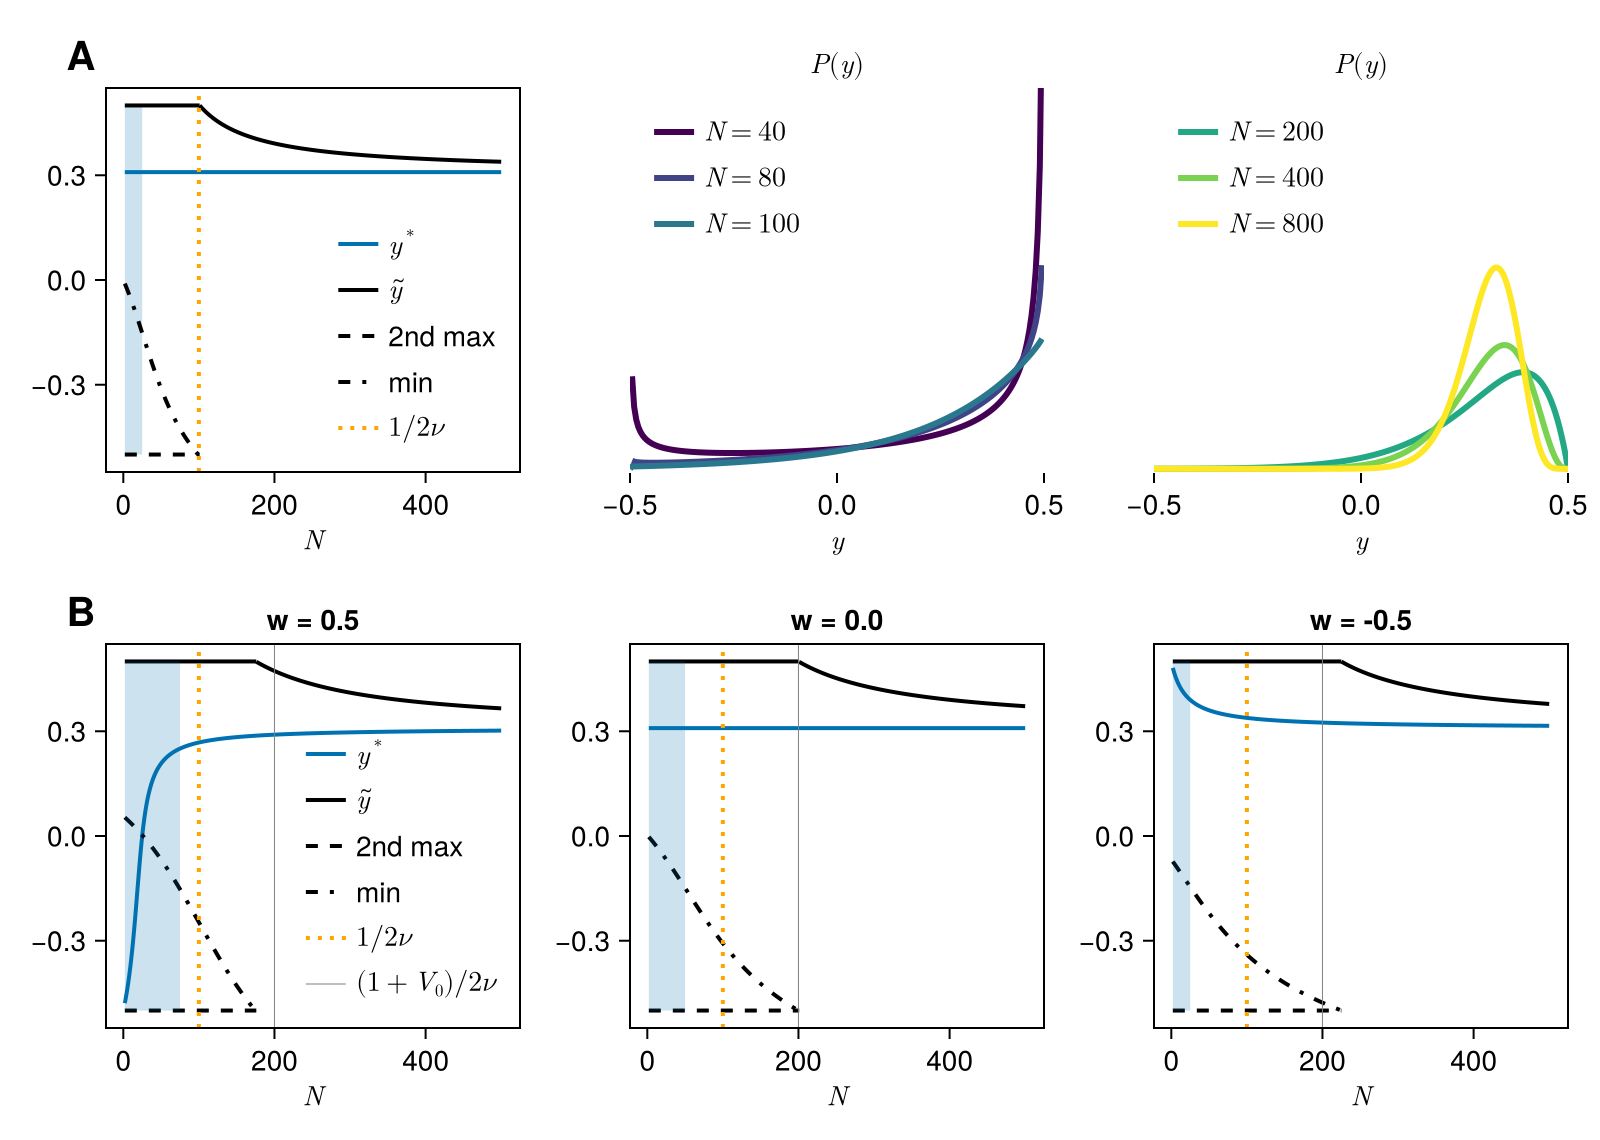

In [96]:
f = Figure(size=(800, 570))
ax = [Axis(f[2, k], xlabel=L"N", xgridvisible=false, ygridvisible=false) for k in 1:3]
pax = [Axis(f[1, k], xgridvisible=false, ygridvisible=false) for k in 1:3]

#params
s = 0.02
nu = 0.005
Nmax = 500

k = 1
for w in [0.5, 0, -0.5]
    inside_fp, inside_ext,Narr_fp, Narr_ext = get_data(w,Nmax,1.)
    jump = findall(x->x>0.6, (inside_ext[2:end]-inside_ext[1:end-1]))[1]
    lines!(ax[k], Narr_fp, inside_fp,linewidth=2,label=L"y^*")
    lines!(ax[k],Narr_ext[jump+1:end],inside_ext[jump+1:end],color=:black,linewidth=2,label=L"\tilde{y}")
    lines!(ax[k], Narr_ext[1:jump+1], -0.5.*ones(jump+1), color=:black, linewidth=2,linestyle=:dash,label="2nd max")
    lines!(ax[k],Narr_ext[1:jump], inside_ext[1:jump],color=:black,linewidth=2,linestyle=:dashdot,label="min")
    lines!(ax[k], Narr_ext[1:jump+1], 0.5.*ones(jump+1), color=:black, linewidth=2)
    vlines!(ax[k],1/(2*nu),color=:orange,linestyle=:dot,linewidth=2,label=L"1/2\nu")
    vlines!(ax[k],(1+1.)/(2*nu),color=:gray,linewidth=0.5,label=L"(1+V_0)/2\nu")
    ax[k].title="w = $w"
    band!(ax[k],[2,(w + (1+1.)/2)/s],[-0.5,-0.5],[0.5,0.5],alpha=0.5)
    k+=1
end
axislegend(ax[1],position=:rb,framevisible = false)

nlines = 6

band!(pax[1],[2,1/(2*s)],[-0.5,-0.5],[0.5,0.5],alpha=0.5)
linside_fp, linside_ext, lNarr_fp, lNarr_ext = get_data(0.,Nmax,0.)
jump = findall(x->x>0.6, (linside_ext[2:end]-linside_ext[1:end-1]))[1]
lines!(pax[1], lNarr_fp, linside_fp,linewidth=2,label=L"y^*")
lines!(pax[1], lNarr_ext[jump+1:end],linside_ext[jump+1:end],color=:black,linewidth=2,label=L"\tilde{y}")
lines!(pax[1], lNarr_ext[1:jump+1], -0.5.*ones(jump+1), color=:black, linewidth=2,linestyle=:dash,label="2nd max")
lines!(pax[1], lNarr_ext[1:jump], linside_ext[1:jump],color=:black,linewidth=2,linestyle=:dashdot,label="min")
lines!(pax[1], lNarr_ext[1:jump+1], 0.5.*ones(jump+1), color=:black, linewidth=2)
vlines!(pax[1],1/(2*nu),color=:orange,linestyle=:dot,linewidth=2,label=L"1/2\nu")


y = range(-0.5,0.5,200)
lines!(pax[2], y, P.(y,40), linewidth=3, color=1,colormap=:viridis, colorrange=(1,nlines), label=L"N=40")
lines!(pax[2], y, P.(y,80), linewidth=3, label=L"N=80", color=2,colormap=:viridis, colorrange=(1,nlines))
lines!(pax[2], y, P.(y,100), linewidth=3, label=L"N=100", color=3,colormap=:viridis, colorrange=(1,nlines))
lines!(pax[3], y, P.(y,200), linewidth=3, label=L"N=200", color=4,colormap=:viridis, colorrange=(1,nlines))
lines!(pax[3], y, P.(y,400), linewidth=3, label=L"N=400", color=5,colormap=:viridis, colorrange=(1,nlines))
lines!(pax[3], y, P.(y,800), linewidth=3, label=L"N=800", color=6,colormap=:viridis, colorrange=(1,nlines))


ylims!(pax[2],(-0.05,6))
ylims!(pax[3],(-0.05,6))
xlims!(pax[2],(-0.5,0.5))
xlims!(pax[3],(-0.5,0.5))

pax[1].xlabel = L"N"
[pax[k].xlabel = L"y" for k in 2:3]
[pax[k].title = L"P(y)" for k in 2:3]
[hideydecorations!(pax[k]) for k in 2:3]
[hidespines!(pax[k]) for k in 2:3]
axislegend(pax[2], position=:lt, framevisible = false)
axislegend(pax[3], position=:lt, framevisible = false)
axislegend(pax[1], position=:rb, framevisible = false)

for (label, layout) in zip(["A", "B"], [f[1,1:3], f[2,1:3]])
    Label(layout[1, 1, TopLeft()], label,
        fontsize = 20,
        font = :bold,
        padding = (0, 5, 5, 0),
        halign = :right)
end
save("../data/plots/bifurc_diags.pdf", f)
f